In [1]:
import regex as re
import numpy as np
from statistics import mean, stdev
import matplotlib
import random
import matplotlib.pyplot as plt
#from bento_bench import bar_plot, parse_elapsed_secs, get_avg_from_table_str, set_size
import pandas as pd
import json
import os
import seaborn as sns
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
#     "font.size": 7,
# })

fio_iops_avg_regex = "(?<=^\s*iops\s*: min=\s*\d*, max=\s*\d*, avg=\s*)\d+\.\d*"
fio_iops_stdev_regex = "(?<=^\s*iops\s*: min=\s*\d*, max=\s*\d*, avg=\s*\d*\.*\d*, stdev=)\d+\.\d*"

# Some are in KiB, some in MiB....
fio_bw_kib_avg_regex = "(?<=^\s*bw \(  KiB\/s\): min=\s*\d*, max=\s*\d*, per=\s*\d*\.*\d*%, avg=\s*)\d+\.\d*"
fio_bw_mib_avg_regex = "(?<=^\s*bw \(  MiB\/s\): min=\s*\d*, max=\s*\d*, per=\s*\d*\.*\d*%, avg=\s*)\d+\.\d*"
fio_bw_kib_stdev_regex = "(?<=^\s*bw \(  KiB\/s\): min=\s*\d*, max=\s*\d*, per=\s*\d*\.*\d*%, avg=\s*\d*\.*\d*, stdev=\s*)\d+\.\d*"
fio_bw_mib_stdev_regex = "(?<=^\s*bw \(  MiB\/s\): min=\s*\d*, max=\s*\d*, per=\s*\d*\.*\d*%, avg=\s*\d*\.*\d*, stdev=\s*)\d+\.\d*"

fio_clat_usec_avg_regex = "(?<=^\s*clat \(usec\): min=\d+, max=\d+\.*\d*k*M*, avg=)\d+\.\d*"
fio_clat_nsec_avg_regex = "(?<=^\s*clat \(nsec\): min=\d+, max=\d+\.*\d*k*M*, avg=)\d+\.\d*"
fio_clat_usec_stdev_regex = "(?<=^\s*clat \(usec\): min=\d+, max=\d+\.*\d*k*M*, avg=\d+\.*\d*, stdev=)\d+\.\d*"
fio_clat_nsec_stdev_regex = "(?<=^\s*clat \(nsec\): min=\d+, max=\d+\.*\d*k*M*, avg=\d+\.*\d*, stdev=)\d+\.\d*"

In [2]:
def get_instructions(df):
    return df.loc[df['event'] == 'instructions', ['val']].iloc[0].item()
def get_cpus(df):
    return df.loc[df['event'] == 'cpu-clock', ['metric_val']].iloc[0].item()
def get_cycles(df):
    return df.loc[df['event'] == 'cycles', ['val']].iloc[0].item()
# We assume here that all the events have been measured for an equal amount of time
def get_time_measured(df):
    return df.loc[df['event'] == 'cpu-clock', ['time_measured']].iloc[0].item() / get_cpus(df)
def get_ipc(df):
    return df.loc[df['event'] == 'instructions', ['metric_val']].iloc[0].item()
def get_branches(df):
    return df.loc[df['event'] == 'branches', ['val']].iloc[0].item()
def get_branch_missrate(df):
    return df.loc[df['event'] == 'branch-misses', ['metric_val']].iloc[0].item()
def get_val(df, metric):
    return df.loc[df['event'] == metric, ['val']].iloc[0].item()
def get_l1_dcache_missrate(df):
    return df.loc[df['event'] == 'L1-dcache-load-misses', ['metric_val']].iloc[0].item()
def get_dtlb_missrate(df):
    return df.loc[df['event'] == 'dTLB-loads-misses', ['metric_val']].iloc[0].item()

In [18]:
perf_stat_colnames = [ "val", "unit", "event", "time_measured", "perctage_measured", "metric_val", "metric_unit"]
targets = {
    "NFS": "./nfs/a906294_zac15_2023-02-26_20:26:58/",
    "Virtio-fs": "./vnfs/096f890_zac15_2023-02-27_16:46:51/",
}
metrics = ["Instructions/OP", "IPC", "Branch missrate", "L1 dCache missrate", "dTLB missrate"]
# perf time_measured is in nsec
runtime = 600
perf_nrep = 5

perf_load = []
iops = []
table = pd.DataFrame(index=metrics)
for i, (conf, folder) in enumerate(targets.items()):
    T1_iops_l = pd.Series(dtype="float")
    for i in range(1, perf_nrep+1):
        f = open(folder + "cpu_load_T1_fio_" + str(i) + ".out")
        matches = re.findall(fio_iops_avg_regex, f.read(), re.MULTILINE)
        T1_iops_l = pd.concat((T1_iops_l, pd.Series(np.array(matches).astype(float).sum())))
    T1_iops = T1_iops_l.mean()

    perf_baseline = pd.DataFrame(columns=["instructions"])
    for i in range(1, perf_nrep+1):
        f = open(folder + "cpu_baseline_perf_" + str(i) + ".out")
        # We skip the first two lines, those are perf event disabled and enabled
        f.readline()
        f.readline()
        raw = pd.read_csv(f, names=perf_stat_colnames)
        row = {
            "instructions": get_instructions(raw)
        }
        perf_baseline = pd.concat((perf_baseline, pd.DataFrame([row])), ignore_index=True)

    perf_load = pd.DataFrame(columns=["instructions", "ipc", "branch_missrate"])
    for i in range(1, perf_nrep+1):
        T1_f = open(folder + "cpu_load_T1_perf_" + str(i) + ".out")
        # We skip the first two lines, those are perf event disabled and enabled
        T1_f.readline()
        T1_f.readline()
        T1_raw = pd.read_csv(T1_f, names=perf_stat_colnames)
        T2_f = open(folder + "cpu_load_T2_perf_" + str(i) + ".out")
        # We skip the first two lines, those are perf event disabled and enabled
        T2_f.readline()
        T2_f.readline()
        T2_raw = pd.read_csv(T2_f, names=perf_stat_colnames)
        T3_f = open(folder + "cpu_load_T3_perf_" + str(i) + ".out")
        # We skip the first two lines, those are perf event disabled and enabled
        T3_f.readline()
        T3_f.readline()
        T3_raw = pd.read_csv(T3_f, names=perf_stat_colnames)
        row = {
            "instructions": get_instructions(T1_raw),
            "ipc": get_ipc(T1_raw),
            "branch_missrate": get_branch_missrate(T1_raw),
            "l1": get_l1_dcache_missrate(T2_raw),
            "dtlb": get_dtlb_missrate(T3_raw),
        }
        perf_load = pd.concat((perf_load, pd.DataFrame([row])), ignore_index=True)

    perf_baseline = perf_baseline.mean()
    perf_load = perf_load.mean()
    
    row = {
        metrics[0]: round((perf_load[0] - perf_baseline[0]) / runtime / T1_iops),
        metrics[1]: perf_load[1],
        metrics[2]: perf_load[2],
        metrics[3]: perf_load[3],
        metrics[4]: perf_load[4]
    }
    table = table.join(pd.DataFrame([row]).transpose())
    table = table.rename(columns={ 0: conf })

table['+/- %'] = (table['NFS'] - table['Virtio-fs']) / table['NFS'] * 100 * -1
    
table = table.round(2).applymap("{0:.2f}".format)
print(table)
table.style.to_latex("cpu_analysis.tex", hrules=True)

                         NFS Virtio-fs   +/- %
Instructions/OP     88453.00  32907.00  -62.80
IPC                     0.57      0.94   64.21
Branch missrate         2.02      1.06  -47.42
L1 dCache missrate      8.82      3.82  -56.65
dTLB missrate           0.14      0.15    7.35


In [4]:
cols = ["conf", "RW", "BS", "QD", "P", "IOPS_avg", "IOPS_stdev", "clat_avg", "clat_stdev", "bw_avg", "bw_stdev"]

def parse_fio(RW, BS, QD, P, conf, folder):
    df = pd.DataFrame(columns=cols)
    
    for rw in RW:
        for bs in BS:
            for qd in QD:
                for p in P:
                    path = "fio_" + rw + "_" + bs + "_" + qd + "_" + p + ".out"
                    f = open(folder + path)
                    f_buf = f.read()

                    # IOPS
                    avg_matches = re.findall(fio_iops_avg_regex, f_buf, re.MULTILINE)
                    stdev_matches = re.findall(fio_iops_stdev_regex, f_buf, re.MULTILINE)
                    row = {
                        "conf": conf,
                        "RW": rw,
                        "BS": bs,
                        "QD": qd,
                        "P": p,
                        "IOPS_avg": np.array(avg_matches).astype(float)[0],
                        "IOPS_stdev": np.array(stdev_matches).astype(float)[0]
                    }

                    # Completion latency
                    avg_matches = np.array(re.findall(fio_clat_usec_avg_regex, f_buf, re.MULTILINE)).astype(float)
                    if (len(avg_matches) == 0):
                        avg_matches = np.array(re.findall(fio_clat_nsec_avg_regex, f_buf, re.MULTILINE)).astype(float)
                        avg_matches = avg_matches / 1000.0 # convert to usec

                    stdev_matches = np.array(re.findall(fio_clat_usec_stdev_regex, f_buf, re.MULTILINE)).astype(float)
                    if (len(stdev_matches) == 0):
                        stdev_matches = np.array(re.findall(fio_clat_nsec_stdev_regex, f_buf, re.MULTILINE)).astype(float)
                        stdev_matches = stdev_matches / 1000.0 # convert to usec

                    row["clat_avg"] = np.array(avg_matches).astype(float)[0]
                    row["clat_stdev"] = np.array(stdev_matches).astype(float)[0]

                    # Bandwidth
                    avg_matches = np.array(re.findall(fio_bw_mib_avg_regex, f_buf, re.MULTILINE)).astype(float)
                    if (len(avg_matches) == 0):
                        avg_matches = np.array(re.findall(fio_bw_kib_avg_regex, f_buf, re.MULTILINE)).astype(float)
                        avg_matches = avg_matches / 1024.0 # convert to MiB

                    stdev_matches = np.array(re.findall(fio_bw_mib_stdev_regex, f_buf, re.MULTILINE)).astype(float)
                    if (len(stdev_matches) == 0):
                        stdev_matches = np.array(re.findall(fio_bw_kib_stdev_regex, f_buf, re.MULTILINE)).astype(float)
                        stdev_matches = stdev_matches / 1024.0 # convert to MiB

                    row["bw_avg"] = np.array(avg_matches).astype(float)[0]
                    row["bw_stdev"] = np.array(stdev_matches).astype(float)[0]

                    df = pd.concat((df, pd.DataFrame([row])), ignore_index=True)
                
    return df

In [17]:
targets = {
    "NFS": "./nfs/a906294_zac15_2023-02-26_20:26:58/",
    "VNFS": "./vnfs/096f890_zac15_2023-02-27_16:46:51/"
}

s = pd.DataFrame(columns=cols)

for (conf, folder) in targets.items():
    df = parse_fio(["randread", "randwrite"], ["1", "4k", "8k", "16k", "32k", "64k", "128k"],
                   ["1", "2", "4", "8", "16", "32", "64", "128"],
                   ["2"], conf, folder)
    s = pd.concat((s, df), ignore_index=True)
    
for (conf, folder) in targets.items():
    df = parse_fio(["randread", "randwrite"], ["32k"],
                   ["128"],
                   ["1", "4", "8"], conf, folder)
    s = pd.concat((s, df), ignore_index=True)

/var/folders/gl/v9m8_2p162103ffg_n80xvvc0000kp/T/ipykernel_16377/678059119.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


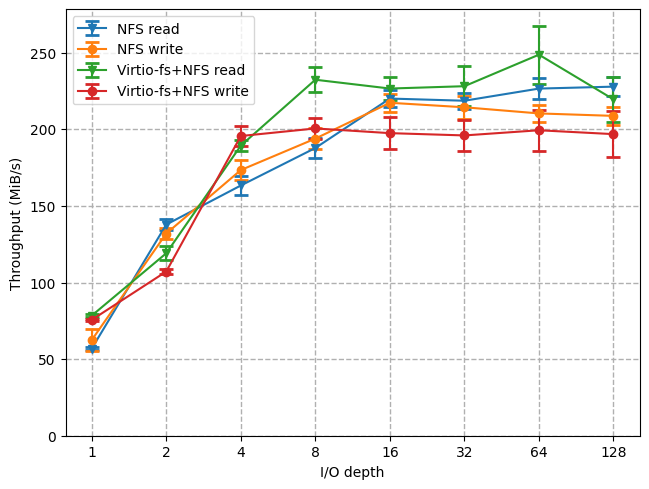

In [6]:
# Throughput
fig, ax = plt.subplots()

BS = '4k'
P = '2'

x = s.loc[(s['RW'] == 'randread') & (s['BS'] == BS) & (s['P'] == P) & (s['conf'] == 'NFS'), 'QD']
NFS_tp = s.loc[(s['BS'] == BS) & (s['conf'] == 'NFS') & (s['P'] == P)]
VNFS_tp = s.loc[(s['BS'] == BS) & (s['conf'] == 'VNFS') & (s['P'] == P)]

ax.errorbar(x, NFS_tp.loc[(NFS_tp['RW'] == 'randread'), 'bw_avg'], NFS_tp.loc[(NFS_tp['RW'] == 'randread'), 'bw_stdev'],
            markersize=6, marker='v', label="NFS read", capsize=5, capthick=2)
ax.errorbar(x, NFS_tp.loc[(NFS_tp['RW'] == 'randwrite'), 'bw_avg'], NFS_tp.loc[(NFS_tp['RW'] == 'randwrite'), 'bw_stdev'],
            markersize=6, marker='o', label="NFS write", capsize=5, capthick=2)

ax.errorbar(x, VNFS_tp.loc[(VNFS_tp['RW'] == 'randread'), 'bw_avg'], VNFS_tp.loc[(VNFS_tp['RW'] == 'randread'), 'bw_stdev'],
            markersize=6, marker='v', label="Virtio-fs+NFS read", capsize=5, capthick=2)
ax.errorbar(x, VNFS_tp.loc[(VNFS_tp['RW'] == 'randwrite'), 'bw_avg'], VNFS_tp.loc[(VNFS_tp['RW'] == 'randwrite'), 'bw_stdev'],
            markersize=6, marker='o', label="Virtio-fs+NFS write", capsize=5, capthick=2)

fig.tight_layout()
ax.grid(which='major', linestyle='dashed', linewidth='1')
ax.set_axisbelow(True)
ax.legend(loc='best')
ax.set_ylim(bottom=0)
ax.set_ylabel("Throughput (MiB/s)")
ax.set_xlabel("I/O depth")

fig.show()

/var/folders/gl/v9m8_2p162103ffg_n80xvvc0000kp/T/ipykernel_16377/352627490.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


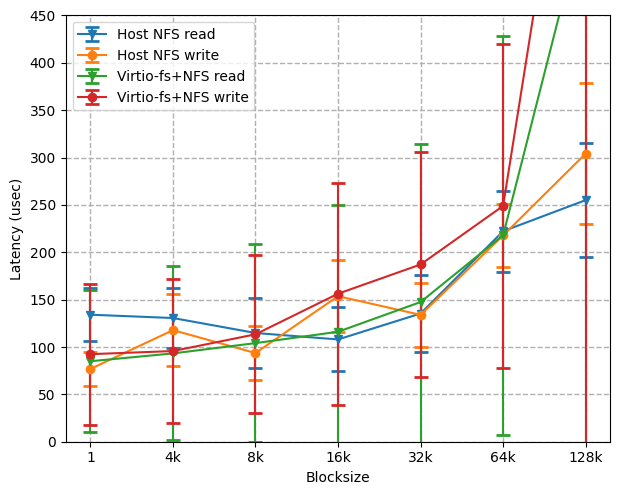

In [7]:
# Latency
# TODO test with P=1

fig, ax = plt.subplots()

QD = '1'
P = '2'

x = s.loc[(s['RW'] == 'randread') & (s['P'] == P) & (s['conf'] == 'NFS') & (s['QD'] == QD), 'BS']
NFS_clat = s.loc[(s['QD'] == QD) & (s['conf'] == 'NFS') & (s['P'] == P)]
VNFS_clat = s.loc[(s['QD'] == QD) & (s['conf'] == 'VNFS') & (s['P'] == P)]


ax.errorbar(x, NFS_clat.loc[(NFS_clat['RW'] == 'randread'), 'clat_avg'], NFS_clat.loc[(NFS_clat['RW'] == 'randread'), 'clat_stdev'],
            markersize=6, marker='v', label="Host NFS read", capsize=5, capthick=2)
ax.errorbar(x, NFS_clat.loc[(NFS_clat['RW'] == 'randwrite'), 'clat_avg'], NFS_clat.loc[(NFS_clat['RW'] == 'randwrite'), 'clat_stdev'],
            markersize=6, marker='o', label="Host NFS write", capsize=5, capthick=2)

ax.errorbar(x, VNFS_clat.loc[(VNFS_clat['RW'] == 'randread'), 'clat_avg'], VNFS_clat.loc[(VNFS_clat['RW'] == 'randread'), 'clat_stdev'],
            markersize=6, marker='v', label="Virtio-fs+NFS read", capsize=5, capthick=2)
ax.errorbar(x, VNFS_clat.loc[(VNFS_clat['RW'] == 'randwrite'), 'clat_avg'], VNFS_clat.loc[(VNFS_clat['RW'] == 'randwrite'), 'clat_stdev'],
            markersize=6, marker='o', label="Virtio-fs+NFS write", capsize=5, capthick=2)


fig.tight_layout()
ax.grid(which='major', linestyle='dashed', linewidth='1')
ax.set_axisbelow(True)
ax.legend(loc='best')
ax.set_ylim(bottom=0, top=450)
ax.set_ylabel("Latency (usec)")
ax.set_xlabel("Blocksize")

fig.show()

/var/folders/gl/v9m8_2p162103ffg_n80xvvc0000kp/T/ipykernel_16377/740982756.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


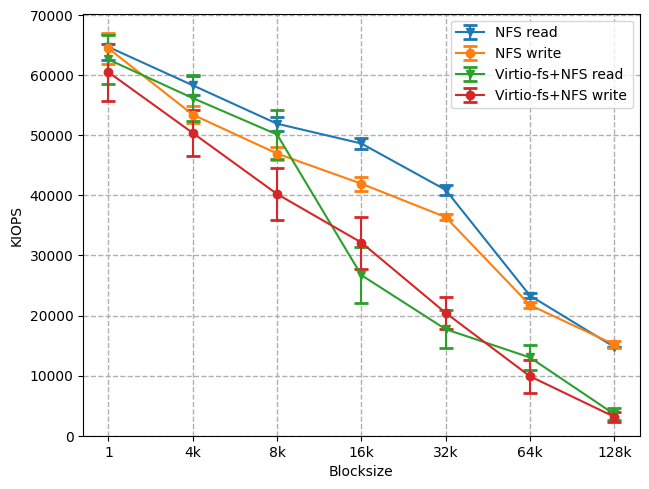

In [8]:
# IOPS

fig, ax = plt.subplots()

QD = '128'

x = s.loc[(s['RW'] == 'randread') & (s['P'] == P) & (s['conf'] == 'NFS') & (s['QD'] == QD), 'BS']
NFS_IOPS = s.loc[(s['QD'] == QD) & (s['conf'] == 'NFS') & (s['P'] == P)]
VNFS_IOPS = s.loc[(s['QD'] == QD) & (s['conf'] == 'VNFS') & (s['P'] == P)]

ax.errorbar(x, NFS_IOPS.loc[(NFS_IOPS['RW'] == 'randread'), 'IOPS_avg'], NFS_IOPS.loc[(NFS_IOPS['RW'] == 'randread'), 'IOPS_stdev'],
            markersize=6, marker='v', label="NFS read", capsize=5, capthick=2)
ax.errorbar(x, NFS_IOPS.loc[(NFS_IOPS['RW'] == 'randwrite'), 'IOPS_avg'], NFS_IOPS.loc[(NFS_IOPS['RW'] == 'randwrite'), 'IOPS_stdev'],
            markersize=6, marker='o', label="NFS write", capsize=5, capthick=2)

ax.errorbar(x, VNFS_IOPS.loc[(VNFS_IOPS['RW'] == 'randread'), 'IOPS_avg'], VNFS_IOPS.loc[(VNFS_IOPS['RW'] == 'randread'), 'IOPS_stdev'],
            markersize=6, marker='v', label="Virtio-fs+NFS read", capsize=5, capthick=2)
ax.errorbar(x, VNFS_IOPS.loc[(VNFS_IOPS['RW'] == 'randwrite'), 'IOPS_avg'], VNFS_IOPS.loc[(VNFS_IOPS['RW'] == 'randwrite'), 'IOPS_stdev'],
            markersize=6, marker='o', label="Virtio-fs+NFS write", capsize=5, capthick=2)

fig.tight_layout()
ax.grid(which='major', linestyle='dashed', linewidth='1')
ax.set_axisbelow(True)
ax.legend(loc='best')
ax.set_ylim(bottom=0)
ax.set_ylabel("KIOPS")
ax.set_xlabel("Blocksize")

fig.show()

/var/folders/gl/v9m8_2p162103ffg_n80xvvc0000kp/T/ipykernel_16377/2796777401.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


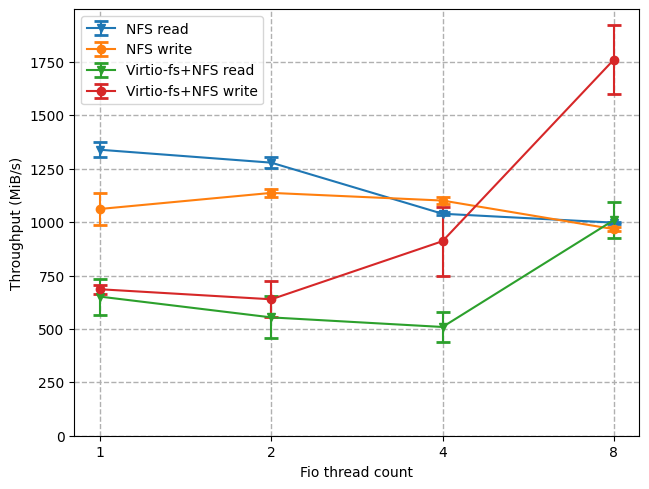

In [9]:
# Multi-core

fig, ax = plt.subplots()

QD = '128'
BS = '32k'

x = s.loc[(s['RW'] == 'randread') & (s['conf'] == 'NFS') & (s['QD'] == QD) & (s['BS'] == BS), 'P'].sort_values()
NFS = s.loc[(s['QD'] == QD) & (s['conf'] == 'NFS') & (s['BS'] == BS)].sort_values(by='P')
VNFS = s.loc[(s['QD'] == QD) & (s['conf'] == 'VNFS') & (s['BS'] == BS)].sort_values(by='P')

ax.errorbar(x, NFS.loc[(NFS['RW'] == 'randread'), 'bw_avg'], NFS.loc[(NFS['RW'] == 'randread'), 'bw_stdev'],
            markersize=6, marker='v', label="NFS read", capsize=5, capthick=2)
ax.errorbar(x, NFS.loc[(NFS['RW'] == 'randwrite'), 'bw_avg'], NFS.loc[(NFS['RW'] == 'randwrite'), 'bw_stdev'],
            markersize=6, marker='o', label="NFS write", capsize=5, capthick=2)

ax.errorbar(x, VNFS.loc[(VNFS['RW'] == 'randread'), 'bw_avg'], VNFS.loc[(VNFS['RW'] == 'randread'), 'bw_stdev'],
            markersize=6, marker='v', label="Virtio-fs+NFS read", capsize=5, capthick=2)
ax.errorbar(x, VNFS.loc[(VNFS['RW'] == 'randwrite'), 'bw_avg'], VNFS.loc[(VNFS['RW'] == 'randwrite'), 'bw_stdev'],
            markersize=6, marker='o', label="Virtio-fs+NFS write", capsize=5, capthick=2)

fig.tight_layout()
ax.grid(which='major', linestyle='dashed', linewidth='1')
ax.set_axisbelow(True)
ax.legend(loc='best')
ax.set_ylim(bottom=0)
ax.set_ylabel("Throughput (MiB/s)")
ax.set_xlabel("Fio thread count")

fig.show()